In [85]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

## building a spam detectior

In [86]:
data = pd.read_csv('https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/sms.tsv.txt'
                   ,sep='\t',header=None,names=['label','message'])
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [87]:
# spam example 
data.loc[data.label == 'spam', 'message']

2       Free entry in 2 a wkly comp to win FA Cup fina...
5       FreeMsg Hey there darling it's been 3 week's n...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
5537    Want explicit SEX in 30 secs? Ring 02073162414...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had your contract mobile 11 Mnths? Latest Moto...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
Name: message, Length: 747, dtype: object

In [88]:
X = data.message
y = data.label

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [89]:
vect = CountVectorizer(max_features=1000, min_df=10) # we'll do a grid search
vect.fit(X_train)

CountVectorizer(max_features=1000, min_df=10)

In [90]:
# vocabulary
len(vect.get_feature_names_out())

803

In [91]:
# document term matrix
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)


In [92]:
# train a multinomial naive Bayes model using X_train_dtm
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)


MultinomialNB()

In [93]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
accuracy_score(y_test, y_pred_class)


0.9856424982053122

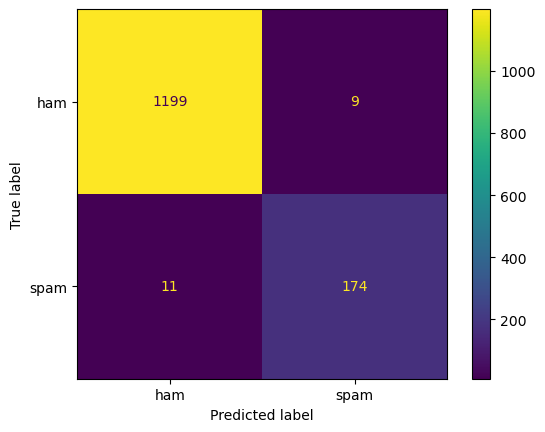

In [94]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_class), display_labels=['ham','spam']).plot()


In [95]:
# print a false negative (spam incorrectly classified as ham)
X_test[(y_test == 'spam') & (y_pred_class == 'ham')]

3132    LookAtMe!: Thanks for your purchase of a video...
5       FreeMsg Hey there darling it's been 3 week's n...
1875    Would you like to see my XXX pics they are so ...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
4298    thesmszone.com lets you send free anonymous an...
4949    Hi this is Amy, we will be sending you a free ...
3991    (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
2821    INTERFLORA - It's not too late to order Inter...
5037    You won't believe it but it's true. It's Incre...
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4514    Money i have won wining number 946 wot do i do...
Name: message, dtype: object

<hr>

11/13/2023 notes

## How does Naive Bayes choose between ham (not spam) and spam

In [96]:
# store vocabulary
words = vect.get_feature_names_out()

In [97]:
# naive bayes counts the number of times each word appears in each label (ham and spam)
print(nb.feature_count_) 
print(nb.classes_) # row 1: ham; row 2: spam

ham_word_count = nb.feature_count_[0]
spam_word_count = nb.feature_count_[1]

[[ 0.  0.  0. ... 13.  2. 33.]
 [23. 10. 10. ...  1.  9.  0.]]
['ham' 'spam']


In [98]:
# put counts into a dataframe
words = pd.DataFrame({'word':words, 'ham':ham_word_count, 'spam':spam_word_count}).set_index('word')

In [99]:
words.sample(10)

,ham,spam
word,,
email,12.0,2.0
mine,14.0,0.0
collection,0.0,21.0
out,157.0,47.0
worth,4.0,10.0
how,227.0,6.0
lar,24.0,0.0
leaving,12.0,0.0
da,118.0,0.0


In [100]:
# add 1 so that we don't divide by 0
words['ham'] = words.ham + 1
words['spam'] = words.spam + 1

In [101]:
# convert counts into frequencies
words['ham'] = words.ham / words.ham.sum()
words['spam'] = words.spam / words.spam.sum()

words.sample(10)

,ham,spam
word,,
late,0.001180,0.000098
frnd,0.000268,0.000589
friends,0.001099,0.000393
tired,0.000349,0.000098
came,0.000617,0.000196
wat,0.002279,0.000196
let,0.001528,0.000393
collection,0.000027,0.002160
mean,0.000322,0.000098


In [102]:
# calculate the reatio ham-to-spam
words['ham_ratio'] = words.ham / words.spam
words['spam_ratio'] = words.spam / words.ham
words.sample(10)

,ham,spam,ham_ratio,spam_ratio
word,,,,
fri,0.000322,0.000196,1.638572,0.610288
people,0.000858,0.000196,4.369524,0.228858
tho,0.000295,0.000098,3.004048,0.332884
always,0.001153,0.000098,11.743097,0.085156
claim,0.000027,0.008737,0.003068,325.893590
far,0.000349,0.000098,3.550239,0.281671
double,0.000188,0.001276,0.147051,6.800348
loads,0.000322,0.000196,1.638572,0.610288
try,0.000965,0.000589,1.638572,0.610288


In [103]:
# top 20 spammy words
words.sort_values('spam_ratio', ascending=False).head(20)

,ham,spam,ham_ratio,spam_ratio
word,,,,
claim,0.000027,0.008737,0.003068,325.893590
prize,0.000027,0.007460,0.003593,278.291155
150p,0.000027,0.004810,0.005573,179.424561
tone,0.000027,0.004712,0.005689,175.762835
guaranteed,0.000027,0.004221,0.006351,157.454206
18,0.000027,0.003828,0.007002,142.807303
cs,0.000027,0.003632,0.007381,135.483852
www,0.000054,0.007166,0.007482,133.652989
1000,0.000027,0.003141,0.008534,117.175223


In [104]:
# top  20 hammy words
words.sort_values('ham_ratio', ascending=False).head(20)

,ham,spam,ham_ratio,spam_ratio
word,,,,
gt,0.006300,0.000098,64.177390,0.015582
lt,0.006220,0.000098,63.358104,0.015783
he,0.004557,0.000098,46.426197,0.021540
she,0.003458,0.000098,35.229291,0.028385
lor,0.003190,0.000098,32.498338,0.030771
da,0.003190,0.000098,32.498338,0.030771
later,0.002976,0.000098,30.313576,0.032989
come,0.004745,0.000196,24.168932,0.041375
too,0.002118,0.000098,21.574527,0.046351


## grid search

Javi always does a grid search because they have so many parameters

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [106]:
pipe = Pipeline(steps=[
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [107]:
param_dict = {'vect__stop_words': [None, 'english'],
              'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': [1.0, 0.9, 0.8],
              'vect__min_df': [1, 10, 20, 50],
              'vect__max_features': [None, 500, 1000, 2000, 5000]}

grid_search = GridSearchCV(pipe, param_dict, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__max_df': [1.0, 0.9, 0.8],
                         'vect__max_features': [None, 500, 1000, 2000, 5000],
                         'vect__min_df': [1, 10, 20, 50],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': [None, 'english']},
             scoring='accuracy', verbose=1)

In [108]:
grid_search.best_params_

{'vect__max_df': 1.0,
 'vect__max_features': 5000,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None}

In [109]:
grid_search.best_score_

0.9839669942411827

In [110]:
pipe_best = grid_search.best_estimator_

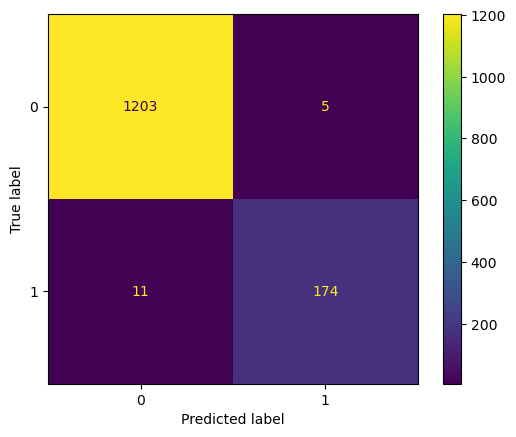

In [111]:
y_test_pred = pipe_best.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot()